## Time Series Analysis

#### Time Series Exchange CPC Analysis

### Matthew Yeseta


In [1]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from scipy.signal import periodogram

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### TIme Series Class for Analysis and Feature Engineering

In [2]:
class TimeSeriesAnalysis:
    def __init__(self, filepath):
        self.series = pd.read_csv(filepath, parse_dates=['timestamp'], index_col='timestamp')
        self.series = self.series.squeeze("columns")  # Squeeze to convert to Series if necessary
        self.dataframe = self._prepare_dataframe()

    def _ensure_complete_date_range(self, series):
        date_range = pd.date_range(start=series.index.min(), end=series.index.max(), freq='D')
        return series.reindex(date_range).fillna(method='ffill')

    def _prepare_dataframe(self):
        dataframe = pd.DataFrame()
        dataframe['timestamp'] = self.series.index.month
        dataframe['value'] = self.series.values
        return dataframe

    def lag_features(self, lag=1):
        temps = pd.DataFrame(self.series.values)
        dataframe = pd.concat([temps.shift(lag), temps], axis=1)
        dataframe.columns = ['t', f't+{lag}']
        return dataframe

    def multiple_lag_features(self, lags=[3, 2, 1]):
        temps = pd.DataFrame(self.series.values)
        dataframe = pd.concat([temps.shift(lag) for lag in lags] + [temps], axis=1)
        dataframe.columns = [f't-{lag}' for lag in reversed(lags)] + ['t+1']
        return dataframe

    def rolling_window_features(self, window_size=2):
        temps = pd.DataFrame(self.series.values)
        shifted = temps.shift(1)
        window = shifted.rolling(window=window_size)
        means = window.mean()
        dataframe = pd.concat([means, temps], axis=1)
        dataframe.columns = ['mean(t-1,t)', 't+1']
        return dataframe

    def expanding_window_features(self):
        temps = pd.DataFrame(self.series.values)
        window = temps.expanding()
        dataframe = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
        dataframe.columns = ['min', 'mean', 'max', 't+1']
        return dataframe

    def arima_forecasting(self, order=(5,1,0)):
        model = ARIMA(self.series, order=order)
        model_fit = model.fit()
        print(model_fit.summary())
        forecast = model_fit.forecast(steps=10)
        return forecast

    def stl_decomposition(self, period=None):
        # Determine period dynamically if not provided
        if period is None:
            period = 365 if len(self.series) >= 365 else 12  # Assume daily data with yearly seasonality or monthly seasonality
        try:
            stl = STL(self.series, seasonal=period)
            result = stl.fit()
            result.plot()
            plt.show()
            return result
        except ValueError as e:
            print(f"Error in STL decomposition: {e}")
            if "Unable to determine period" in str(e):
                print("Attempting with a different period...")
                # Try with a different period
                period = 12
                stl = STL(self.series, seasonal=period)
                result = stl.fit()
                result.plot()
                plt.show()
                return result
            else:
                raise e

    def spectral_analysis(self):
        f, Pxx_den = periodogram(self.series)
        plt.figure()
        plt.semilogy(f, Pxx_den)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.show()

    def spectral_analysis(self):
        f, Pxx_den = periodogram(self.series)
        plt.figure()
        plt.semilogy(f, Pxx_den)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.show()

    def plot_yearly_data(self):
        groups = self.series.groupby(Grouper(freq='A'))
        years = DataFrame()
        for name, group in groups:
            # Ensure the group is reindexed to a full year
            date_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
            group = group.reindex(date_range).fillna(method='ffill')
            years[name.year] = group.values
        years.plot(subplots=True, legend=False)
        plt.show()

    def plot_boxplot(self):
        self.dataframe.boxplot(column='value', by='timestamp')
        plt.title('Monthly CPC Exchange Value Boxplot')
        plt.suptitle('')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()

    def plot_matshow(self):
        pivoted = self.dataframe.pivot_table(values='value', index='timestap', columns='month')
        plt.matshow(pivoted, aspect='auto', origin='lower')
        plt.title('CPC Exchange Value Time Matrix')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.colorbar(label='Value')
        plt.show()

    def plot_lag(self):
        lag_plot(self.series)
        plt.title('CPC Exchange Value Time Lag Plot')
        plt.show()

    def plot_autocorrelation(self):
        autocorrelation_plot(self.series)
        plt.title('Autocorrelation Plot on CPC Exchange Value')
        plt.show()

    def plot_density(self):
        self.series.plot(kind='kde')
        plt.title('CPC Exchange Value Density Plot')
        plt.show()

    def plot_histogram(self):
        self.series.hist()
        plt.title('CPC Exchange Value Histogram')
        plt.show()

    def plot_yearly(self):
        groups = self.series.groupby(Grouper(freq='A'))
        for name, group in groups:
            plt.figure()
            plt.plot(group)
            plt.title(f'Year {name.year}')
            plt.show()


In [3]:
# Example usage
tsadataframe = pd.read_csv('exchange-2_cpc_results.csv', parse_dates=True)
tsadataframe.head(5)
tsa = TimeSeriesAnalysis('exchange-2_cpc_results.csv')

# Print the initial dataframe
#print(tsa.dataframe.head(5))
tsadataframe.head(5)

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


In [4]:
print(type(tsa))

<class '__main__.TimeSeriesAnalysis'>


In [5]:
# Lag features
print(tsa.lag_features(lag=1).head(5))

          t       t+1
0       NaN  0.081965
1  0.081965  0.098972
2  0.098972  0.065314
3  0.065314  0.070663
4  0.070663  0.102490


In [6]:
# Multiple lag features
print(tsa.multiple_lag_features(lags=[3, 2, 1]).head(5))

        t-1       t-2       t-3       t+1
0       NaN       NaN       NaN  0.081965
1       NaN       NaN  0.081965  0.098972
2       NaN  0.081965  0.098972  0.065314
3  0.081965  0.098972  0.065314  0.070663
4  0.098972  0.065314  0.070663  0.102490


In [7]:
# Rolling window features
print(tsa.rolling_window_features(window_size=2).head(5))

   mean(t-1,t)       t+1
0          NaN  0.081965
1          NaN  0.098972
2     0.090468  0.065314
3     0.082143  0.070663
4     0.067988  0.102490


In [8]:
# Expanding window features
print(tsa.expanding_window_features().head(5))

        min      mean       max       t+1
0  0.081965  0.081965  0.081965  0.098972
1  0.081965  0.090468  0.098972  0.065314
2  0.065314  0.082084  0.098972  0.070663
3  0.065314  0.079228  0.098972  0.102490
4  0.065314  0.083881  0.102490  0.123395


In [9]:
# ARIMA forecasting
forecast = tsa.arima_forecasting(order=(5,1,0))
print("Forecast:", forecast)

C:\Users\matth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1624
Model:                 ARIMA(5, 1, 0)   Log Likelihood                4163.386
Date:                Mon, 22 Jul 2024   AIC                          -8314.772
Time:                        16:57:26   BIC                          -8282.419
Sample:                             0   HQIC                         -8302.767
                               - 1624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0112      0.018      0.617      0.537      -0.024       0.047
ar.L2         -0.0278      0.021     -1.295      0.195      -0.070       0.014
ar.L3          0.0283      0.022      1.262      0.2

C:\Users\matth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\matth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Data Visualization
 STL decomposition
 Spectral Analysis.
 Line Plots.
 Histograms and Density Plots.
 Box and Whisker Plots.
 Heat Maps.
 Lag Plots or Scatter Plots.
 Autocorrelation Plots.

In [10]:
# STL decomposition
#stl_result = tsa.stl_decomposition(period=365)

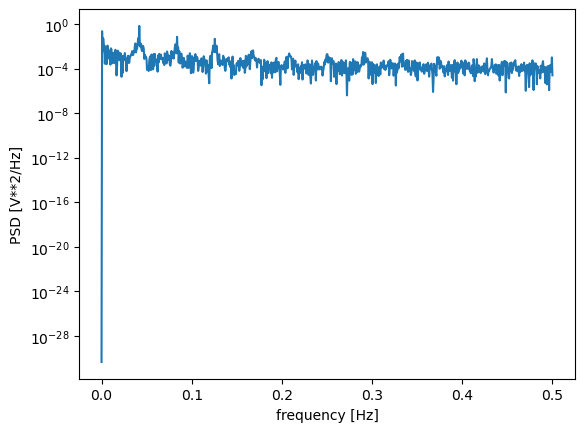

In [11]:
# Spectral analysis
tsa.spectral_analysis()

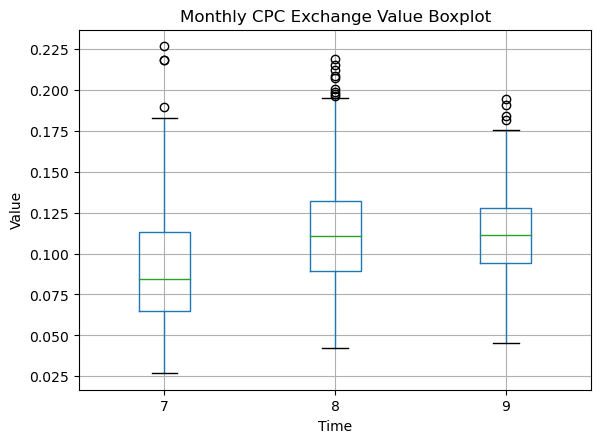

In [12]:
# Plot boxplot
tsa.plot_boxplot()

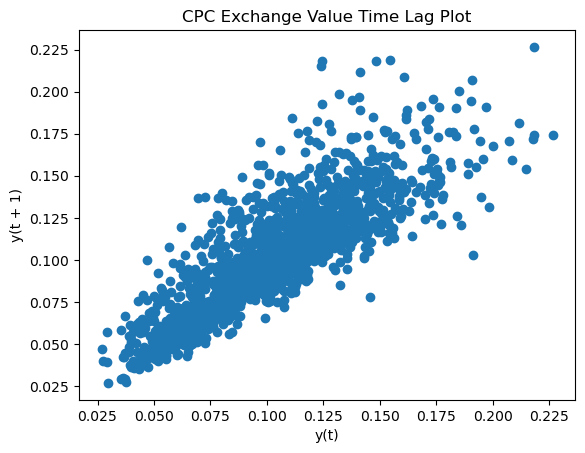

In [13]:
# Plot lag
tsa.plot_lag()

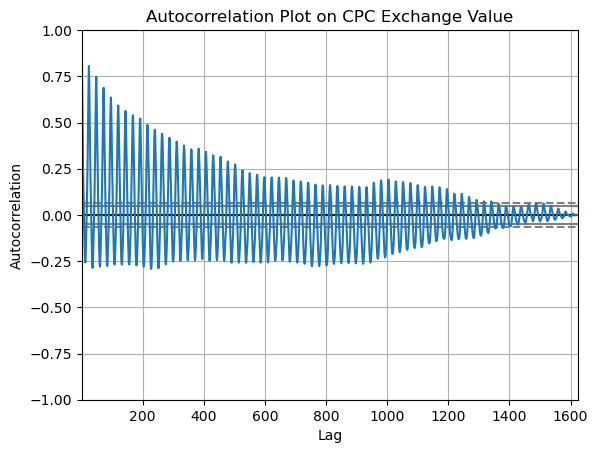

In [14]:
# Plot autocorrelation
tsa.plot_autocorrelation()

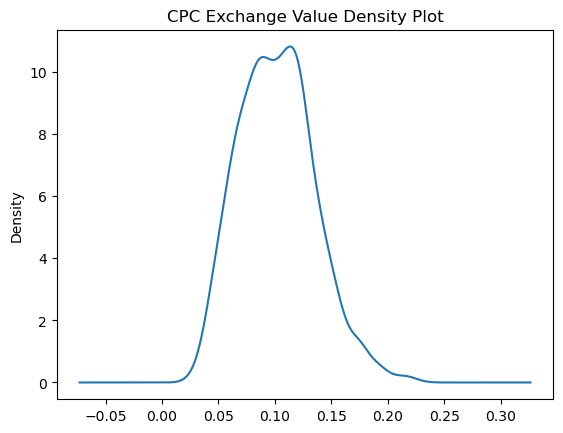

In [15]:
# Plot density
tsa.plot_density()

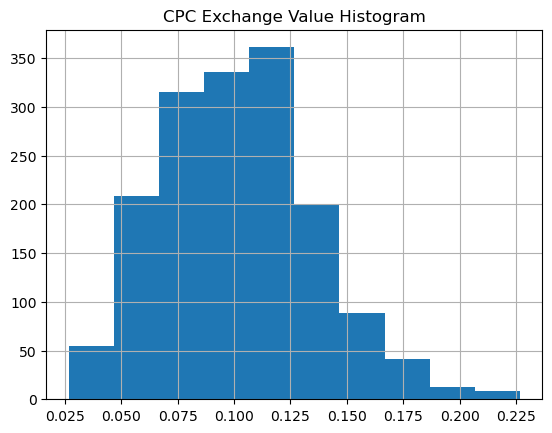

In [16]:
# Plot histogram
tsa.plot_histogram()

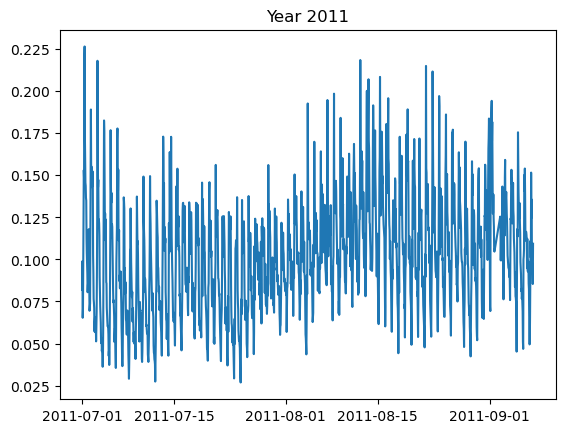

In [17]:
# Plot yearly
tsa.plot_yearly()

we see cycles of strong negative and positive correlation. This captures the relationship of an observation with past observations in the same and opposite seasons or times of year. Sine waves like those seen in this example are a strong sign of seasonality in the dataset.